# Status de Requições de Materiais

## Componentes

- Raphael Ramos
- Ernane Ferreira

## Dataset

Usamos um dos datasets das Requisições de Materiais no grupo de Materiais, dos Dados Abertos da UFRN. Abaixo uma descrição dele

In [58]:
# Importa a biblioteca pandas com o alias 'pd'
import pandas as pd

# Lê um arquivo CSV como delimitador ;
rm = pd.read_csv('data/all_data.csv', delimiter=',')

# Exibe as primeiras linhas do DataFrame 'rm' para visualizar os dados
rm.head()

,numero,ano,requisicao,data,id_unidade_requisitante,unidade_requisitante,id_unidade_custo,unidade_custo,observacoes,grupo_material,convenio,status,tipo_requisicao,almoxarifado,valor
0,2469,1998,2469/1998,29/12/1998,283,EDITORA UNIVERSITÁRIA,283,EDITORA UNIVERSITÁRIA,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 13,80"
1,2468,1998,2468/1998,29/12/1998,1463,RESIDENCIAS UNIVERSITÁRIAS,1463,RESIDENCIAS UNIVERSITÁRIAS,NaN,GAS ENGARRAFADO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 84,00"
2,2470,1998,2470/1998,29/12/1998,253,NÚCLEO PERMANENTE DE CONCURSOS,253,NÚCLEO PERMANENTE DE CONCURSOS,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 4,60"
3,2471,1998,2471/1998,29/12/1998,285,HOSPITAL UNIVERSITARIO ANA BEZERRA,285,HOSPITAL UNIVERSITARIO ANA BEZERRA,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 34,50"
4,2460,1998,2460/1998,28/12/1998,1423,DIRETORIA DE LOGÍSTICA - PROAD,1423,DIRETORIA DE LOGÍSTICA - PROAD,NaN,MATERIAL DE LIMPEZA E PRODUTOS DE HIGIENIZACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 86,56"


## Contexto

Quando uma unidade precisa de algum material, ela abre uma requisição para o almoxarifado. Nessa requisição, deve ter o preço estimado desse material e a unidade que vai custear esse material. Assim, o almoxarifado pode aprová-la e dar início a ordem de compra.

## Ideia

Neste dataset, queremos que, dada uma requisição, prever ele vai ser negada ou autorizada pelo almoxarifado. Além disso, investigar qual perfil das requisições que têm mais chances de serem aprovadas.

## Preprocessamento

Como esse dataset possui registros de devolução e requisições que envolvem serviços, vamos considerar apenas as requisições de material da instituição

In [59]:
df = rm[rm['tipo_requisicao'] == 'REQUISIÇÃO DE MATERIAL']

Algumas colunas em nada agregam ao nosso objetivo, portanto vamos retirá-las

In [60]:
df = df.drop(['numero','ano','requisicao','data','observacoes','grupo_material','tipo_requisicao','unidade_custo','id_unidade_custo','id_unidade_requisitante'], axis=1)

A coluna status é multivalorada, mas apenas nos importa saber se a requisição foi negada ou não.

In [61]:
# Filtrar apenas requisições negadas, autorizadas e que tiveram a compra efetuada
df = df[df['status'].isin(['NEGADA', 'AUTORIZADA', 'COMPRA', 'LIQUIDADA', 'EM_LIQUIDACAO'])]

# Substituir 'NEGADA' por 1 e outros valores por 0 na coluna 'status'
df['status'] = df['status'].apply(lambda x: 1 if x == 'NEGADA' else 0)

Vamos categorizar as unidades requisitantes por grupos que a princípio conhecemos

In [62]:
# Função para realizar a substituição
def categorize_request_unit(valor):
    if valor.startswith("ADMINISTRAÇÃO"):
        return 0
    elif valor.startswith("DIRETORIA"):
        return 1
    elif valor.startswith("SECRETARIA"):
        return 2
    elif valor.startswith("DEPARTAMENTO"):
        return 3
    elif valor.startswith("COORDENAÇÃO"):
        return 4
    elif valor.startswith("ALMOXARIFADO"):
        return 5
    elif valor.startswith("ASSESSORIA"):
        return 6
    elif valor.startswith("ASSISTÊNCIA"):
        return 7
    elif valor.startswith("BIBLIOTECA"):
        return 8
    elif valor.startswith("PRÓ-REITORIA"):
        return 9
    elif valor.startswith("HUOL"):
        return 10
    else:
        # Outros
        return 11  

# Aplicar a função à coluna "unidade_requisitante" e criar uma nova coluna com os valores substituídos
df['unidade_requisitante'] = df['unidade_requisitante'].apply(categorize_request_unit)

As colunas convenio e almoxarifado são interessantes, mas são categóricas. Portanto, precisão ser tratadas. Abaixo uma função que facilita esse trabalho

In [63]:
from sklearn.preprocessing import LabelEncoder

def categorize(dataframe, column):
    """
    Recebe um dataframe e a coluna com os dados categóricos que se quer rotular

    Args:
        dataframe (object DataFrame)
        column (string)
    """
    # Identificar categorias de column
    data = {category for category in set(dataframe[column])} 
    
    # Traduzir cada categoria para numeros
    label_encoder = LabelEncoder()
    
    # Atualiza no dataframe
    dataframe[column] = label_encoder.fit_transform(dataframe[column])
    
    # Obtenha as categorias originais e seus rótulos numéricos
    categories = label_encoder.classes_
    labels = label_encoder.transform(categories)

    # Visualizar mapeamento
    display(pd.DataFrame({'Categoria':categories, 'Rótulo Numérico': labels}))

In [64]:
categorize(df, 'convenio')

,Categoria,Rótulo Numérico
0,False,0
1,True,1


In [65]:
categorize(df, 'almoxarifado')

,Categoria,Rótulo Numérico
0,ALMOXARIFADO - CB,0
1,ALMOXARIFADO - CCET,1
2,ALMOXARIFADO - CCHLA,2
3,ALMOXARIFADO - CCHLA - PORTARIA 097/2014,3
4,ALMOXARIFADO - CCS,4
5,ALMOXARIFADO - CCSA,5
6,ALMOXARIFADO - CT,6
7,ALMOXARIFADO CENTRAL,7
8,ALMOXARIFADO DE MATERIAIS DE MANUTENÇÃO DE IMÓ...,8
9,ALMOXARIFADO HUAB,9


A coluna `valor` precisa ser transformada em valores decimais

In [66]:
import re

rgx_remove_prefix = r'R\$|\s'
rgx_only_last_point = r'\.(?=[^.]*\.)'

df.loc[:,'valor'] = df['valor'].apply(lambda value: re.sub(rgx_only_last_point, '', re.sub(rgx_remove_prefix, '', value).replace(',', '.')))
df.loc[:,'valor'] = df['valor'].astype(float)

Verificar linhas que possuem valores NaN

In [67]:
df.isna().sum()

unidade_requisitante    0
convenio                0
status                  0
almoxarifado            0
valor                   0
dtype: int64

O proximo passo é categorizar as colunas dos valores baseando-se pelo box plot apresentado abaixo

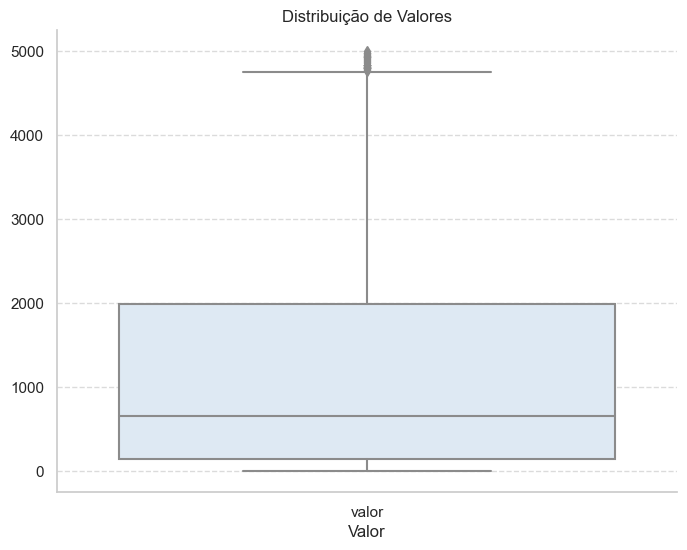

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar os valores que estão dentro de um intervalo mais apropriado
df_copy = df[df['valor'] < 5000]

# Definir uma paleta de cores personalizada (opcional)
custom_palette = sns.color_palette("Blues")

# Criar um boxplot com Seaborn
plt.figure(figsize=(8, 6)) 
sns.set(style="whitegrid")

ax = sns.boxplot(data=df_copy[['valor']], palette=custom_palette)
ax.set_title('Distribuição de Valores')
ax.set_xlabel('Valor')

# Adicione um grid de fundo mais claro
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remova a moldura superior e direita
sns.despine()

# Mostre o boxplot
plt.show()

In [69]:
def categorize_value(value):
    if value < 1000:
        return 0
    elif value >= 1000 and value <= 2000:
        return 1
    elif value > 2000 and value < 4000:
        return 2
    return 3

df.loc[:,'valor'] = df['valor'].apply(categorize_value)

Abaixo é possível ver quantas requisições foram negadas (status 0) e quantas foram aprovadas (status 1)

In [70]:
df['status'].value_counts()

status
0    3374
1     801
Name: count, dtype: int64

In [71]:
df

,unidade_requisitante,convenio,status,almoxarifado,valor
39292,8,0,0,13,3
39841,11,0,0,13,3
39842,11,0,0,13,1
40717,3,0,0,13,1
40802,3,0,0,13,1
...,...,...,...,...,...
620056,0,0,1,7,1
621466,1,0,1,8,2
621869,5,0,1,7,0
622018,0,0,1,7,0


## Avaliação de classificador

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve

# Classe para avaliar as técnicas supervisionadas
class AssessClassifier:
    """
    Inicialização da avaliação do classificador

    Parâmetros:
        df    (DataFrame)      : dataframe onde se encontram os dados
        clf   (sklearn object) : classificador
        label (string)         : nome da coluna do rótulo no dataframe
    """
    def __init__(self, df, clf, label):
        # Armazena o dataframe e o classificador nas propriedades
        self.df = df
        self.clf = clf
        
        # Separando X (features) e y (label)
        X = df.drop(label, axis=1)
        y = df.status

        # Divisao treino e test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.20, random_state=0)

    """
    Treinamento do classificador
    """
    def train(self):
        # Treinar classificador
        self.clf = self.clf.fit(self.X_train, self.y_train)
        # Verificar score com dados de treino
        print('Score do treinamento: ', self.clf.score(self.X_train, self.y_train))

    """
    Teste do classificador
    """
    def test(self):
        # Faça a predição
        self.y_pred = self.clf.predict(self.X_test)

    """
    Plotar matriz de confusão
    """
    def get_cm(self):
        return confusion_matrix(self.y_test,self.y_pred)

    """
    Plotar curva ROC
    """
    def get_roc(self):
        y_prob = self.clf.predict_proba(self.X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(self.y_test, y_prob)
        return fpr, tpr

    """
    Mostrar acurácia, precisão e sensibilidade do modelo
    """
    def get_metrics(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        return accuracy, precision, recall       

## Técnicas supervisionadas

### Gradient Boosting

In [73]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb_clf = HistGradientBoostingClassifier(
    # TODO ajustar parametros HistGradientBoosting
)

gb = AssessClassifier(df, gb_clf, 'status')
gb.train()
gb.test()

Score do treinamento:  0.9637724550898203


### Floresta Aleatória

In [74]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    # TODO ajustar parametros do RandomForest
)

rf = AssessClassifier(df, rf_clf, 'status')
rf.train()
rf.test()

Score do treinamento:  0.9649700598802395


### Comparações

#### Métricas de acurácia, sensibilidade e precisão

In [75]:
rf_accuracy, rf_precision, rf_recall = rf.get_metrics()
gb_accuracy, gb_precision, gb_recall = gb.get_metrics()

metrics = dict()
metrics['classifier'] = ['HistGradientBoostingClassifier', 'RandomForestClassifier']
metrics['accuracy'] = [gb_accuracy, rf_accuracy]
metrics['precision'] = [gb_precision, rf_precision]
metrics['recall'] = [gb_recall, rf_recall]

pd.DataFrame(metrics)

,classifier,accuracy,precision,recall
0,HistGradientBoostingClassifier,0.960479,0.885906,0.891892
1,RandomForestClassifier,0.962874,0.897959,0.891892


#### Matriz de confusão

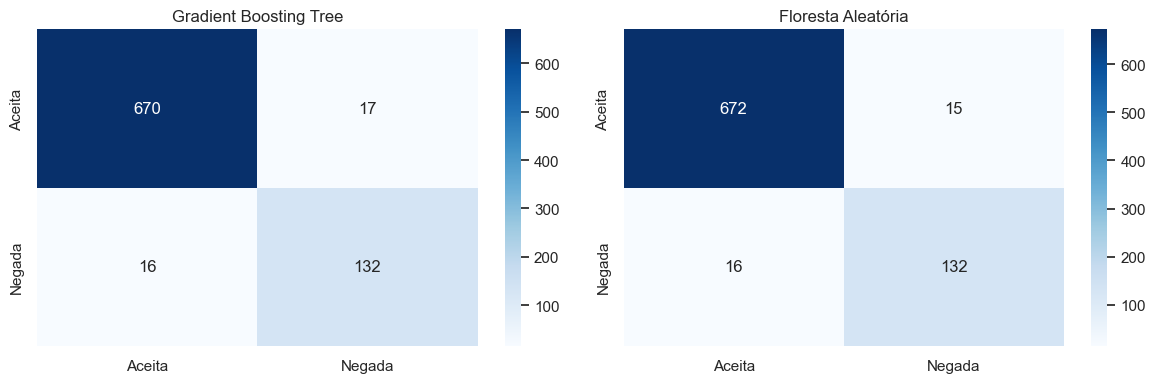

In [76]:
cm1 = gb.get_cm()
cm2 = rf.get_cm()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm1, annot=True, fmt="d", ax=axes[0], cmap="Blues", xticklabels=["Aceita", "Negada"], yticklabels=["Aceita", "Negada"])
axes[0].set_title("Gradient Boosting Tree")

sns.heatmap(cm2, annot=True, fmt="d", ax=axes[1], cmap="Blues", xticklabels=["Aceita", "Negada"], yticklabels=["Aceita", "Negada"])
axes[1].set_title("Floresta Aleatória")

plt.tight_layout()
plt.show()

#### Curva ROC

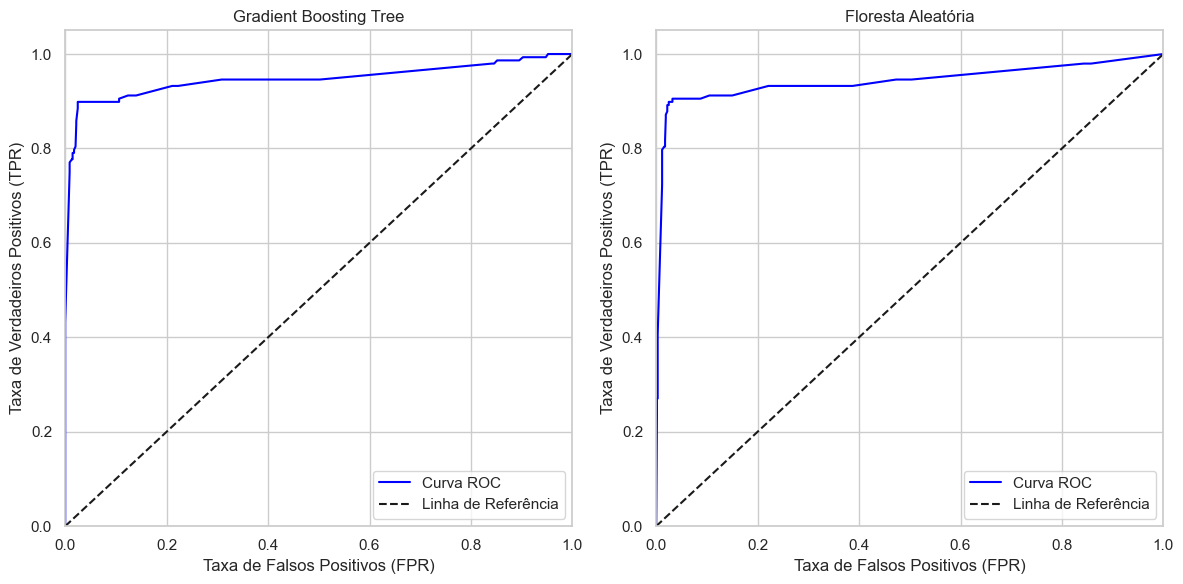

In [77]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
fpr_gb, tpr_gb = gb.get_roc()
plt.plot(fpr_gb, tpr_gb, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Linha de Referência')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Gradient Boosting Tree')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
fpr_rf, tpr_rf = rf.get_roc()
plt.plot(fpr_rf, tpr_rf, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Linha de Referência')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Floresta Aleatória')
plt.legend(loc='lower right')

plt.tight_layout()

plt.show()            

## Técnica não supervisionada

### K-Means

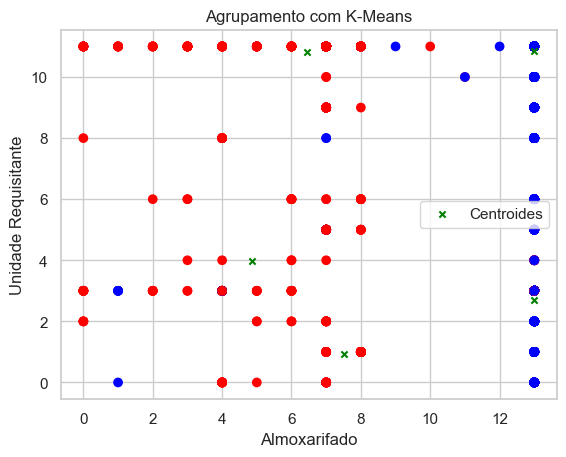

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import MinMaxScaler

# Colunas desejadas
X = df[['almoxarifado', 'unidade_requisitante']]

# Aplicar o algoritmo K-Means
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters,n_init=10)
kmeans.fit(X)
df['cluster'] = kmeans.labels_

# Plotar os agrupamentos colorindo as linhas com base na coluna 'status'
colors = {0: 'blue', 1: 'red'}
df['color'] = df['status'].map(colors)
plt.scatter(df['almoxarifado'], df['unidade_requisitante'], c=df['color'])
plt.xlabel('Almoxarifado')
plt.ylabel('Unidade Requisitante')
plt.title('Agrupamento com K-Means')

# Plotar os centroides
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='green', marker='x', s=20, label='Centroides')
plt.legend()

# Mostrar figura
plt.show()

Os agrupamentos feitos pelo Kmeans retrata que há o almoxarifado 13 tende a aceitar boa parte das requisições a ele enviadas de várias unidades requisitantes, visto que observa-se um conjunto de pontos em azul alinhados verticalmente que representam requisições aceitas. No entanto, há um grupo maior de rejeições nos agrupamentos feitos mais à esquerda pelos almoxarifados de 4 a 8

In [79]:
# Calcular coeficiente de silhueta e inercia
silhouette_avg = silhouette_score(X, kmeans.labels_)
inertia = kmeans.inertia_

print(f"Coeficiente de Silhueta: {silhouette_avg}")
print(f"Inércia do Modelo: {inertia}")

Coeficiente de Silhueta: 0.8750736945704473
Inércia do Modelo: 4689.637723418271
